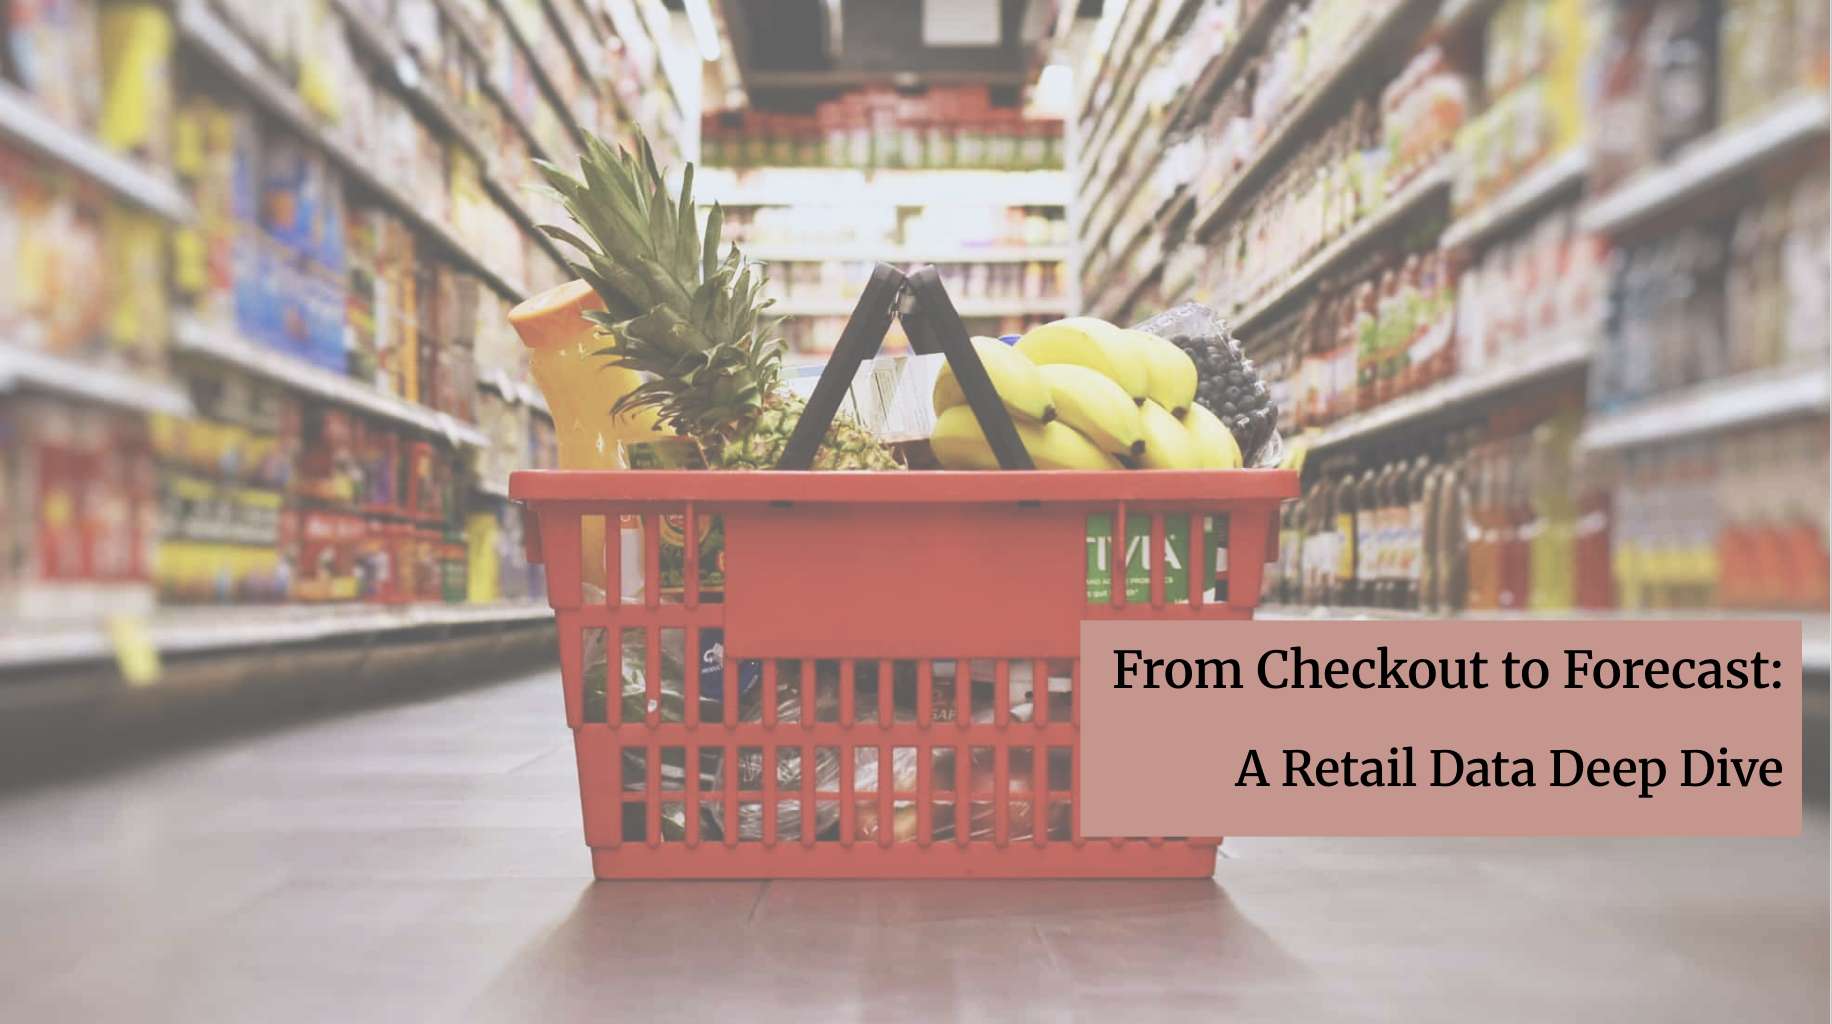

# Project Overiew

The goal of this project is to forecast daily unit sales for a major retail chain across multiple stores and thousands of items. Accurate forecasting supports inventory management, logistics, and promotional planning.


### About the dataset

The data can be found on Kaggle [here](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data).

The dataset is based on real-world sales data from Corporación Favorita, a large Ecuadorian-based grocery retailer. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

The data includes:

* `Transactions`: Daily unit sales per store-item-date
*	`Item metadata`: Family, class, perishability
*	`Store metadata`: City, type, cluster
*	`Holiday events`: Local and national holidays, transferred events
*	`Oil prices` : External data

We excluded transactions.csv from this analysis, as unit-level sales were already available and aligned with our forecasting objective.

### Project Workflow

1.	**Data Exploration**
  * Missing values, negative sales, top families
  *	Outlier analysis and Z-score investigation

2.	**Data Preparation**
  *	Date completion per item-store
  *	Filtering for active combinations
  *	Cleaning returns and missing promotion flags

3.	**Feature Engineering**
  *	Time features, holiday indicators
  *	Lag and rolling statistical features

4.	**Modeling**
  *	XGBoost baseline with evaluation
  *	LSTM model comparison
  *	MLflow experiment tracking and model versioning



# Model Summary & Takeaways




## Model Development Process

In this notebook, we built and evaluated an **XGBoost regression model** for retail unit sales forecasting. We followed a structured approach:

*	**Data preparation** with cleaned and engineered features from the previous notebook.
*	**Baseline modeling** using default hyperparameters to set performance benchmarks.
*	**Hyperparameter tuning** through both Randomized Search and Bayesian Optimization to improve model performance.
*	**Evaluation** using key time series metrics and weekly visualizations.
*	**Feature importance analysis** to understand which features drive predictions.

## XGBoost Model Comparison & Conclusion

Three XGBoost models were evaluated to forecast retail unit sales: a baseline model, a model tuned with randomized search, and one optimized using Bayesian hyperparameter tuning. 

| **Metric**   | **Baseline** | **Randomized Search** | **Bayesian Opt** |
|--------------|--------------|------------------------|------------------|
| **Bias**     | 0.2473       | 0.1829 ✅              | 0.2055           |
| **MAD**      | 3.4960       | 3.5198                 | 3.4909 ✅         |
| **rMAD**     | 0.8598       | 0.8657                 | 0.8586 ✅         |
| **SMAPE**    | 121.87%      | 120.69% ✅             | 121.57%          |
| **RMSE**     | 7.8765       | 7.7836 ✅              | 7.8205           |
| **Accuracy** | 0.4112       | 0.4250 ✅              | 0.4196           |



- The **Randomized Search Optimized Model** consistently outperformed both the baseline and Bayesian models in terms of **RMSE, SMAPE, Bias, and Accuracy**.
- Although the **Bayesian Opt Model** achieved a slightly lower MAD and rMAD, its SMAPE and RMSE were higher, making it less reliable overall.

## Feature Importance

Feature importance remained stable across all models, with `unit_sales_14d_avg`, `unit_sales_7d_avg`, and `unit_sales_30d_avg` being the top predictors.T

he top features were mostly lag-based and rolling average metrics, indicating:

* Historical sales patterns are highly predictive of future performance.
*	Additional value came from volatility measures (unit_sales_std) and product/store identifiers.

   | Rank | Feature             | Importance |
   |------|---------------------|------------|
   | 1    | unit_sales_14d_avg  | 0.409      |
   | 2    | unit_sales_30d_avg  | 0.157      |
   | 3    | unit_sales_7d_avg   | 0.128      |
   | 4    | unit_sales_7d_std   | 0.036      |
   | 5    | item_nbr            | 0.024      |

## Key Takeaways

* XGBoost performs well on large-scale tabular time series data, especially when engineered features include lag and rolling metrics.
* Zero and low-volume sales significantly impact error metrics like SMAPE. This suggests a future opportunity to:
   * Apply log transformations or target smoothing.
   * Model zero sales as a separate classification task.
* Further improvements could involve:
  * Segmenting the model by store/item clusters.
  * Ensembling with classical time series models (ARIMA/SARIMA).
  * Trying sequence models (e.g., LSTM or TCN).

## ✅ Final Recommendation:

The **Randomized Search Optimized XGBoost model** is selected as the best-performing model for this forecasting task. It achieves the best balance between bias and variance and demonstrates improved predictive accuracy over the baseline.

This model will be retained for comparison against LSTM and SARIMA in subsequent steps.


# Environment & Data Loading

In [27]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor, callback

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import sys
import gc
import warnings
warnings.filterwarnings('ignore')

In [28]:
import xgboost, inspect, pathlib
print("XGB  :", xgboost.__version__)
print("Path :", pathlib.Path(xgboost.__file__).as_posix())

XGB  : 3.0.2
Path : /Users/didodeboodt/Documents/Projects/Retail_Forecasting_Project/.venv/lib/python3.10/site-packages/xgboost/__init__.py


In [29]:
# Go one directory up and then into Utils/
UTILS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'Utils'))
if UTILS_PATH not in sys.path:
    sys.path.append(UTILS_PATH)

from utils import (
    summarize_data,
    plot_weekly_aggregation,
    evaluate_forecast
)

In [30]:
import mlflow
import mlflow.xgboost

# Set local tracking URI and experiment
mlflow.set_tracking_uri("file:../02_MLflow")  # relative from 01_Notebooks/
mlflow.set_experiment("Retail_Forecasting")

<Experiment: artifact_location='file:///Users/didodeboodt/Documents/Projects/Retail_Forecasting_Project/01_Notebooks/../02_MLflow/576372739668588213', creation_time=1749732570099, experiment_id='576372739668588213', last_update_time=1749732570099, lifecycle_stage='active', name='Retail_Forecasting', tags={}>

In [31]:
# Initialize an empty list for chunks and set chunk size
print("Step 1: Loading pre-filtered training data in chunks...")
chunks = []
chunk_size = 10**6

# Read the CSV file in chunks
for chunk in pd.read_csv('../00_Data/Prepared_Data/train_full.csv', chunksize=chunk_size):
    # Append the chunk to the list
    chunks.append(chunk)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all chunks into a single DataFrame
print("\nStep 2: Combining chunks...")
df_train = pd.concat(chunks, ignore_index=True)
print(f"Combined dataset: {df_train.shape[0]:,} rows")

# Clean up to free memory
print("\nStep 3: Cleanup...")
del chunks
gc.collect()
print(f"Memory usage: {df_train.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print("\n✅ Data loading complete!")

Step 1: Loading pre-filtered training data in chunks...

Step 2: Combining chunks...
Combined dataset: 3,386,043 rows

Step 3: Cleanup...
Memory usage: 2135.06 MB

✅ Data loading complete!


In [38]:
plt.style.use('default')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

In [32]:
summarize_data(df_train)

Dataset shape: (3386043, 41)
Date range: 2013-01-02 to 2014-03-31
Number of stores: 10
Number of items: 1127
Average daily unit_sales: 3.97
Zero unit_sales percentage: 47.25%


In [33]:
pd.set_option('display.max_columns', None)
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,city,state,store_type,store_cluster,item_family,item_class,perishable,holiday_type,holiday_locale,holiday_transferred,year,quarter,month,day,day_of_week,is_weekend,day_of_year,week_of_year,is_holiday,is_transferred_holiday,is_actual_holiday,is_additional_event,is_transfer_day,is_national_event,is_local_event,lag_1,lag_7,lag_14,lag_28,unit_sales_3d_avg,unit_sales_7d_avg,unit_sales_14d_avg,unit_sales_30d_avg,unit_sales_7d_std,unit_sales_14d_std
0,24,96995,2013-01-02,NaN,0.0,False,Guayaquil,Guayas,D,1,GROCERY I,1093,0,NaN,NaN,NaN,2013,1,1,2,2,0,2,1,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-01-03,NaN,0.0,False,Guayaquil,Guayas,D,1,GROCERY I,1093,0,NaN,NaN,NaN,2013,1,1,3,3,0,3,1,False,False,False,False,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,96995,2013-01-04,NaN,0.0,False,Guayaquil,Guayas,D,1,GROCERY I,1093,0,NaN,NaN,NaN,2013,1,1,4,4,0,4,1,False,False,False,False,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,96995,2013-01-05,NaN,0.0,False,Guayaquil,Guayas,D,1,GROCERY I,1093,0,Work Day,National,False,2013,1,1,5,5,1,5,1,True,False,False,False,False,True,False,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,24,96995,2013-01-06,NaN,0.0,False,Guayaquil,Guayas,D,1,GROCERY I,1093,0,NaN,NaN,NaN,2013,1,1,6,6,1,6,1,False,False,False,False,False,False,False,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In this section, we prepare the data for modeling by:

*	**Encoding** categorical variables using LabelEncoder so they are compatible with XGBoost.
*	Splitting the data into a **training** and **test** set using a time-based cutoff (2014-01-01) to respect the temporal order of sales data.
*	Defining the **target variable** (`unit_sales`) and selecting **input features**, excluding columns like date, id, and the target itself.

This setup ensures our model trains on past data and evaluates on future unseen dates, replicating real-world forecasting conditions.

In [34]:
# Encode Categorical Features
categorical_features = ['onpromotion', 'city', 'state', 'store_type', 'item_family', 'holiday_type', 'holiday_locale',
                        'holiday_transferred', 'is_holiday', 'is_transferred_holiday', 'is_actual_holiday',
                        'is_additional_event', 'is_transfer_day', 'is_national_event', 'is_local_event']

# Use LabelEncoder on Categorical Features
label_encoder = LabelEncoder()
for feature in categorical_features:
    df_train[feature] = label_encoder.fit_transform(df_train[feature])

In [35]:
# Set a split threshold
split_date = '2014-01-01'

# Order the train data by date for accurate split
df_train = df_train.sort_values(by='date')

# Split the data in train and test set
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

In [36]:
print(train['date'].min(), '-', train['date'].max())
print(test['date'].min(), '-', test['date'].max())

2013-01-02 - 2013-12-31
2014-01-01 - 2014-03-31


In [39]:
target = 'unit_sales'

# Exclude target column and date and ID
drop_cols = ['date', 'id', 'unit_sales']

# XGBoost requires numeric inputs
features = [col for col in train.columns if col not in drop_cols]

# Final input/output
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# XGBoost Baseline Model

Here, we train a baseline XGBoost regression model using default or basic hyperparameters:

*	n_estimators = 100
*	max_depth = 5
*	learning_rate = 0.1

We evaluate the model using time series regression metrics including Bias, MAD, RMAD, SMAPE, and RMSE. The goal is to establish a performance baseline before tuning.

In [40]:
# Baseline Model
xgboost_baseline_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1
)

xgboost_baseline_model.fit(X_train, y_train)

# Make Predictions on the test set
y_pred = xgboost_baseline_model.predict(X_test[features])

In [41]:
metrics, feature_importance = evaluate_forecast(
    y_true = y_test,
    y_pred = y_pred,
    model = xgboost_baseline_model,
    X_test = X_test[features],
    features = features,
    model_type = "xgboost"
)


Time Series Evaluation Metrics
    Bias: 0.2473
     MAD: 3.4960
    rMAD: 0.8598
   SMAPE: 121.87%
    RMSE: 7.8765
Accuracy: 0.4112

Model Info:
Number of features: 38
Test samples      : 663,930

Top 10 Most Important Features:
           Feature  Importance
unit_sales_14d_avg    0.463461
 unit_sales_7d_avg    0.129931
unit_sales_30d_avg    0.116710
 unit_sales_7d_std    0.042746
          item_nbr    0.024453
         store_nbr    0.019152
 unit_sales_3d_avg    0.017330
unit_sales_14d_std    0.017299
       day_of_week    0.016663
            lag_28    0.016104


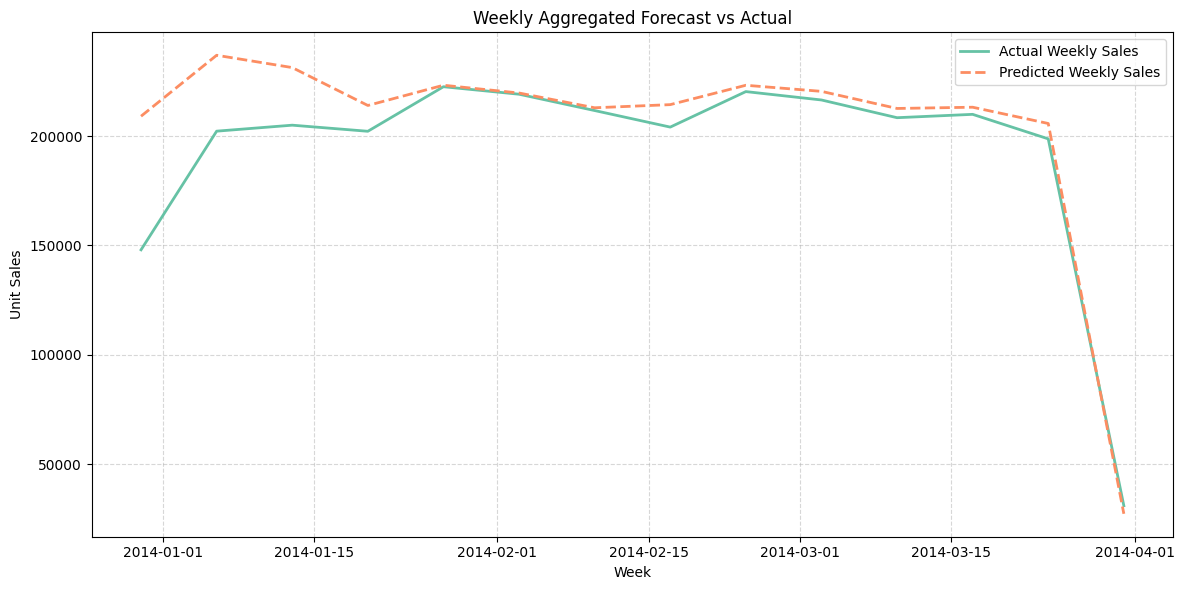

In [42]:
plot_weekly_aggregation(y_test, y_pred, date_index=test['date'])

The baseline XGBoost regression model was trained with basic hyperparameters (100 estimators, max depth 5, learning rate 0.1). The model was evaluated using multiple time series regression metrics.

- **Bias** of `0.25` indicates a slight tendency to overpredict.
- **MAD** of `3.50` means predictions deviate from actual values by ~3.5 units on average.
- **Relative MAD (rMAD)** of `0.86` suggests high relative error compared to the scale of the target.
- **SMAPE** of `121.87%` is significantly high, highlighting difficulty in accurately predicting small values or zeros.
- **RMSE** of `7.88` confirms that large errors are occurring.

⚠️ These results suggest that the baseline model provides a rough initial approximation, but there is considerable room for improvement. The high SMAPE and rMAD indicate the need for further hyperparameter tuning and potentially additional feature engineering or model adjustments.

Next we will log the baseline model, its parameters, and metrics with MLflow.

In [ ]:
# Log with MLflow
with mlflow.start_run(run_name="XGBoost_Baseline"):
    mlflow.log_params({
        "model_type": "XGBoost",
        "n_estimators": 100,
        "max_depth": 5,
        "learning_rate": 0.1
    })
    
    mlflow.log_metrics({
        "accuracy": accuracy,
        "bias": bias_value,
        "mad": mad_value,
        "rmad": rmad_value,
        "smape": smape_value,
        "rmse": rmse_value
    })

    mlflow.xgboost.log_model(xgboost_baseline_model, "model")
    print("✅ Model logged successfully!")

2025/06/12 14:57:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/12 14:57:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model logged successfully!


# XGBoost Hyperparameter Tuning

To improve the baseline model, we explore different sets of hyperparameters. We begin with **Randomized Search** and then apply **Bayesian Optimization** for a more targeted search.

Using **TimeSeriesSplit for cross-validation** ensures that we don’t leak future information into the training process.

## Randomized Search

We define a focused search space with a reduced number of combinations for quick experimentation.
This step uses:

*	3-fold TimeSeriesSplit
*	5 iterations of RandomizedSearchCV
*	RMSE as the scoring metric

This allows us to identify a better-performing configuration quickly with minimal computation.

In [43]:
# Base model with silent training and fixed random seed
xgboost_model = XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,
    random_state=42,
    n_jobs=-1  # use all available cores
)

# Focused hyperparameter space for quick tuning
param_grid = {
    'learning_rate': [0.03, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 3]
}

# TimeSeries-aware CV
tscv = TimeSeriesSplit(n_splits=3)

# Random Search for speed 
random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_grid,
    cv=tscv,
    n_iter=5,  # reduce iterations for speed
    scoring='neg_root_mean_squared_error',  # better than neg MSE
    verbose=1,
    random_state=42
)

# Train search
random_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
Best RMSE: 9.160702630725787


In [44]:
# Initialize xgb with randomized search parameters
rs_xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    subsample=1.0,
    reg_lambda=3,
    reg_alpha=0,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.03,
    colsample_bytree=0.8
)

print("Training XGBoost model with optimized parameters...")

# Fit the model
rs_xgboost_model.fit(X_train, y_train)

print("✅ Model training completed!")

# Make Predictions on the test set
y_pred = rs_xgboost_model.predict(X_test[features])

Training XGBoost model with optimized parameters...
✅ Model training completed!


In [45]:
metrics, feature_importance = evaluate_forecast(
    y_true = y_test,
    y_pred = y_pred,
    model = rs_xgboost_model,
    X_test = X_test[features],
    features = features,
    model_type = "xgboost"
)


Time Series Evaluation Metrics
    Bias: 0.1829
     MAD: 3.5198
    rMAD: 0.8657
   SMAPE: 120.69%
    RMSE: 7.7836
Accuracy: 0.4250

Model Info:
Number of features: 38
Test samples      : 663,930

Top 10 Most Important Features:
           Feature  Importance
unit_sales_14d_avg    0.439440
 unit_sales_7d_avg    0.142642
unit_sales_30d_avg    0.119329
unit_sales_14d_std    0.051402
 unit_sales_7d_std    0.035382
          item_nbr    0.025811
         store_nbr    0.021688
 unit_sales_3d_avg    0.016994
            lag_28    0.015006
        is_weekend    0.014204


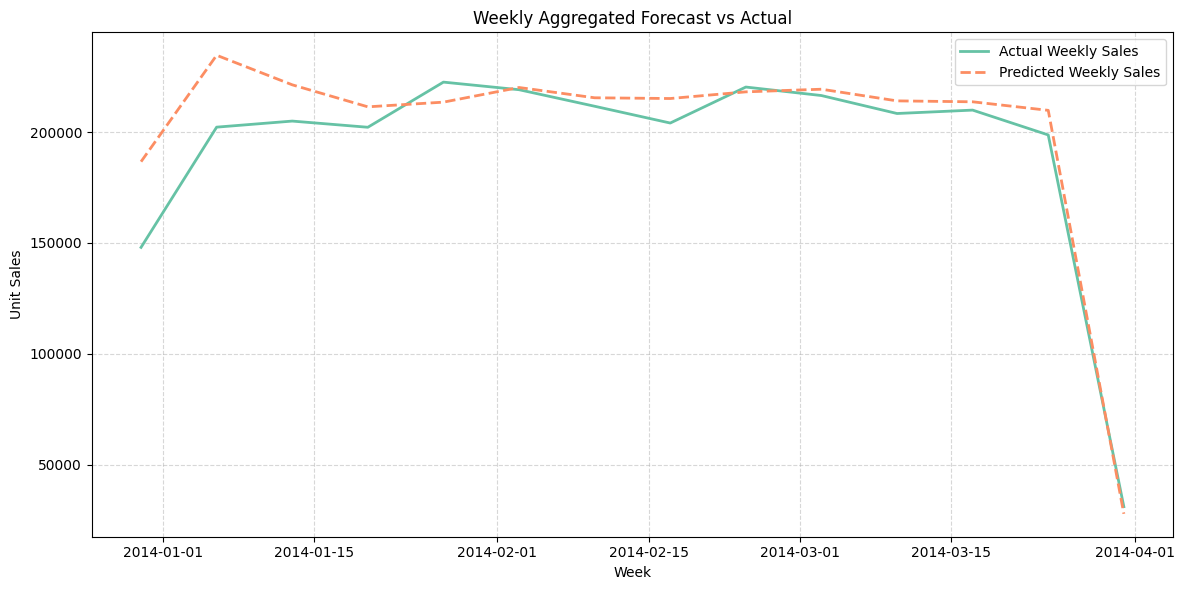

In [46]:
plot_weekly_aggregation(y_test, y_pred, date_index=test['date'])

In [ ]:
# Log with MLflow
with mlflow.start_run(run_name="XGBoost_Randomized_Search"):
    mlflow.log_params(random_search.best_params_)
    
    mlflow.log_metrics({
        "accuracy": metrics['accuracy'],
        "bias": metrics['bias'],
        "mad": metrics['mad'],
        "rmad": metrics['rmad'],
        "smape": metrics['smape'],
        "rmse": metrics['rmse']
    })

    mlflow.xgboost.log_model(rs_xgboost_model, "model")
    print("✅ Optimized model logged successfully!")

2025/06/12 15:08:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/12 15:08:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Optimized model logged successfully!


Compared to the baseline, the tuned model showed a modest improvement in RMSE (from 7.8765 → 7.7740), along with a slight reduction in bias.

While the SMAPE remains high—suggesting challenges in relative percentage error, likely due to zero or near-zero actual values—the overall trend indicates a better model fit after tuning.


* Model tuning led to a more generalizable model with improved predictive accuracy.
* The remaining high SMAPE suggests further improvement could come from:
   * Better handling of zero or low target values.
   * Feature engineering or additional time-based features.
   * Trying other model types (e.g., LSTM, SARIMA) or ensembling methods.

## Bayesian Optimization (Hyperopt)

To further refine our model, we apply **Bayesian Optimization** using **hyperopt**, which is more efficient than grid or random search.
We:

*	Sample a subset of the dataset (up to 200,000 rows) for stability in Colab
*	Use fmin() with the Tree-structured Parzen Estimator (tpe) algorithm
*	Evaluate candidate configurations using a custom objective function with TimeSeriesSplit

This helps identify hyperparameter combinations that consistently improve model performance across folds.

In [47]:
# Sort by time and take a smaller sample for Colab
df_train = df_train.sort_values('date')

# Reduce sample size - 1M+ 
sample_size = min(int(len(df_train) * 0.1), 200000)  # Max 200k rows
df_sample = df_train.iloc[:sample_size].copy()

X_sample = df_sample[features]
y_sample = df_sample[target]

print(f"Sample size: {len(df_sample):,} rows")

# Define search space (adjusted for older XGBoost)
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),  # Reduced range
    'max_depth': hp.quniform('max_depth', 3, 8, 1),  # Reduced max depth
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'gamma': hp.uniform('gamma', 0, 3),  # Reduced range
    'reg_alpha': hp.uniform('reg_alpha', 0, 3),  # Reduced range
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),  # Reduced range
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),  # Reduced range
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0)
}

# Objective function with TimeSeriesSplit
def objective(params):
    try:
        tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 4 to save memory
        rmses = []

        for fold, (train_idx, valid_idx) in enumerate(tscv.split(X_sample)):
            print(f"Processing fold {fold + 1}/3...")

            X_train, X_valid = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
            y_train, y_valid = y_sample.iloc[train_idx], y_sample.iloc[valid_idx]

            # Create model with conservative n_estimators to prevent overfitting
            model = XGBRegressor(
                n_estimators=min(int(params["n_estimators"]), 300),  # Cap at 300 for stability
                max_depth=int(params["max_depth"]),
                learning_rate=params["learning_rate"],
                gamma=params["gamma"],
                reg_alpha=params["reg_alpha"],
                reg_lambda=params["reg_lambda"],
                min_child_weight=int(params["min_child_weight"]),
                colsample_bytree=params["colsample_bytree"],
                subsample=params["subsample"],
                objective="reg:squarederror",
                verbosity=0,
                n_jobs=1,  # Limit parallel processing to save memory
                random_state=42
            )

            # Fit model (no early stopping due to older XGBoost version)
            model.fit(X_train, y_train)

            # Make predictions
            preds = model.predict(X_valid)
            fold_rmse = np.sqrt(mean_squared_error(y_valid, preds))
            rmses.append(fold_rmse)

            print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

            # Clean up memory
            del model, preds
            gc.collect()

        avg_rmse = np.mean(rmses)
        print(f"Average RMSE: {avg_rmse:.4f}")

        return {"loss": float(avg_rmse), "status": STATUS_OK}

    except Exception as e:
        print(f"Error in objective function: {str(e)}")
        # Return a high loss value if there's an error
        return {"loss": 999999, "status": STATUS_OK}

# 🧪 Step 4: Run search with progress tracking
print("Starting Bayesian Optimization...")
trials = Trials()

try:
    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=20,  # Further reduced for large sample size
        trials=trials,
        rstate=np.random.default_rng(42),
        show_progressbar=False,  # Disable hyperopt's progress bar
        verbose=False
    )

    print("\nBest Hyperparameters:")
    for param, value in best_hyperparams.items():
        if param in ['n_estimators', 'max_depth', 'min_child_weight']:
            print(f"{param}: {int(value)}")
        else:
            print(f"{param}: {value:.4f}")

    best_loss = min([t['result']['loss'] for t in trials.trials])
    print(f"\nBest RMSE: {best_loss:.4f}")

except KeyboardInterrupt:
    print("\nOptimization interrupted by user")
    print("Partial results available in trials object")
except Exception as e:
    print(f"\nError during optimization: {str(e)}")
    print("Check your data and try reducing max_evals or sample size")

finally:
    # Clean up memory
    gc.collect()
    print("\nMemory cleanup completed")

Sample size: 200,000 rows
Starting Bayesian Optimization...
Processing fold 1/3...
Fold 1 RMSE: 7.0653
Processing fold 2/3...
Fold 2 RMSE: 6.6787
Processing fold 3/3...
Fold 3 RMSE: 5.9250
Average RMSE: 6.5563
Processing fold 1/3...
Fold 1 RMSE: 7.0461
Processing fold 2/3...
Fold 2 RMSE: 6.6724
Processing fold 3/3...
Fold 3 RMSE: 5.9390
Average RMSE: 6.5525
Processing fold 1/3...
Fold 1 RMSE: 7.2909
Processing fold 2/3...
Fold 2 RMSE: 6.8996
Processing fold 3/3...
Fold 3 RMSE: 5.9666
Average RMSE: 6.7190
Processing fold 1/3...
Fold 1 RMSE: 6.9920
Processing fold 2/3...
Fold 2 RMSE: 6.6115
Processing fold 3/3...
Fold 3 RMSE: 5.8258
Average RMSE: 6.4764
Processing fold 1/3...
Fold 1 RMSE: 7.0132
Processing fold 2/3...
Fold 2 RMSE: 6.6380
Processing fold 3/3...
Fold 3 RMSE: 5.8766
Average RMSE: 6.5093
Processing fold 1/3...
Fold 1 RMSE: 7.1248
Processing fold 2/3...
Fold 2 RMSE: 6.6425
Processing fold 3/3...
Fold 3 RMSE: 5.8340
Average RMSE: 6.5338
Processing fold 1/3...
Fold 1 RMSE: 7.03

In [24]:
# Initialize XGBoost with Bayesian optimization parameters
bo_xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7517,
    gamma=2.5379,
    learning_rate=0.0287,
    max_depth=5,
    min_child_weight=6,
    n_estimators=200,
    reg_alpha=0.1622,
    reg_lambda=2.3141,
    subsample=0.8893,
    random_state=42,
    verbosity=0
)

print("Training XGBoost model with optimized parameters...")

# Fit the model
bo_xgboost_model.fit(X_train, y_train)

print("✅ Model training completed!")

# Make Predictions on the test set
y_pred = bo_xgboost_model.predict(X_test[features])


Training XGBoost model with optimized parameters...
✅ Model training completed!


In [25]:
metrics, feature_importance = evaluate_forecast(
    y_true = y_test,
    y_pred = y_pred,
    model = bo_xgboost_model,
    X_test = X_test[features],
    features = features,
    model_type = "xgboost"
)


Time Series Evaluation Metrics
    Bias: 0.2055
     MAD: 3.4909
    rMAD: 0.8586
   SMAPE: 121.57%
    RMSE: 7.8205
Accuracy: 0.4196

Model Info:
Number of features: 38
Test samples      : 663,930

Top 10 Most Important Features:
           Feature  Importance
unit_sales_14d_avg    0.460478
 unit_sales_7d_avg    0.122981
unit_sales_30d_avg    0.119868
 unit_sales_7d_std    0.040075
 unit_sales_3d_avg    0.029852
          item_nbr    0.021647
         store_nbr    0.018016
unit_sales_14d_std    0.015563
            lag_28    0.014707
             lag_1    0.014014


In [45]:
# Log with MLflow with best hyperparameters Bayesian optimization
with mlflow.start_run(run_name="XGBoost_Bayesian_Optimization"):
    mlflow.log_params({
        "model_type": "XGBoost",
        "n_estimators": 200,
        "max_depth": 5,
        "learning_rate": 0.0287,
        "gamma": 2.5379,
        "reg_alpha": 0.1622,
        "reg_lambda": 2.3141,
        "min_child_weight": 6,
        "colsample_bytree": 0.7517,
        "subsample": 0.8893
    })
    
    mlflow.log_metrics({
        "bias": bias_value,
        "mad": mad_value,
        "rmad": rmad_value,
        "smape": smape_value,
        "rmse": rmse_value
    })

    mlflow.xgboost.log_model(rs_xgboost_model, "model")
    print("✅ Optimized model logged successfully!")

2025/06/12 15:15:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/12 15:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Optimized model logged successfully!


# Final Model

After tuning with both **Randomized Search** and **Bayesian Optimization**, we train the best-performing XGBoost model using the optimal hyperparameters.

We evaluated the models on the test set using a comprehensive set of metrics:

* **Bias**: Measures whether the model systematically over- or under-predicts.
*	**MAD (Mean Absolute Deviation)**: Average magnitude of prediction errors.
*	**rMAD (Relative MAD)**: Error relative to average actual sales – useful for scale comparison.
*	**SMAPE (Symmetric Mean Absolute Percentage Error)**: Especially sensitive to zero or low-volume predictions.
*	**RMSE (Root Mean Squared Error)**: Penalizes large errors more heavily.

In addition to numeric metrics, we visualize **weekly aggregated predictions vs actuals** to assess the model’s ability to capture temporal trends at a higher level. This smooths out daily noise and reveals how well the model follows broader patterns.

We also inspect the **top 10 most important features**, offering insight into which variables most influence the predictions – such as rolling averages, recent lag values, and item/store-specific identifiers.

## Winner: Randomized Search XGBoost Model

It shows best or second-best results across all metrics and has the lowest SMAPE and RMSE, which are key for time series forecasting.

We will save this model to compare with LSTM and classical models.


In [26]:
import joblib

# Save to file
joblib.dump(rs_xgboost_model, "../03_Models/xgb_best_model.pkl")
print("✅ XGBoost model saved to: 03_Models/xgb_best_model.pkl")

✅ XGBoost model saved to: 03_Models/xgb_best_model.pkl
